<a href="https://colab.research.google.com/github/emilymacris/ds4002-project3/blob/main/project_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install earthengine-api
!pip install geemap

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 12.9 MB/s eta 0:00:00


In [2]:
import ee
import geemap

In [3]:
ee.Authenticate()
ee.Initialize(project='ee-bdf7bz')


In [4]:
aoi = ee.Geometry.Rectangle([-147.5, 60.7, -146.5, 61.3])  # Columbia Glacier area

# Use the new Collection 2 dataset
image = ee.ImageCollection('LANDSAT/LC08/C02/T1_L2') \
    .filterBounds(aoi) \
    .filterDate('2021-06-01', '2021-08-31') \
    .median() \
    .clip(aoi)

Map = geemap.Map(center=[60.9, -147.0], zoom=9)
Map.addLayer(image, {'bands': ['SR_B4', 'SR_B3', 'SR_B2'], 'min': 0, 'max': 30000}, 'True Color')
Map


Map(center=[60.9, -147.0], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDataGU…

In [15]:
# Compute NDSI (snow/ice index)
ndsi = image.normalizedDifference(['SR_B3', 'SR_B6']).rename('NDSI')

# Compute NDVI (vegetation index)
ndvi = image.normalizedDifference(['SR_B5', 'SR_B4']).rename('NDVI')

# Add them to your image
image = image.addBands([ndsi, ndvi])

In [16]:
stats = image.reduceRegion(
    reducer=ee.Reducer.mean().combine(
        ee.Reducer.minMax(), sharedInputs=True
    ),
    geometry=aoi,
    scale=30,
    maxPixels=1e9  # set this high enough
)

print(stats.getInfo())

{'NDSI_1_max': 0.6992718423254874, 'NDSI_1_mean': 0.27645546402542265, 'NDSI_1_min': -0.24924760601915186, 'NDSI_max': 0.6992718423254874, 'NDSI_mean': 0.27645546402542265, 'NDSI_min': -0.24924760601915186, 'NDVI_1_max': 0.49193415019168607, 'NDVI_1_mean': 0.0023312195551571458, 'NDVI_1_min': -0.24774450769641793, 'NDVI_max': 0.49193415019168607, 'NDVI_mean': 0.0023312195551571458, 'NDVI_min': -0.24774450769641793, 'QA_PIXEL_max': 55052, 'QA_PIXEL_mean': 29214.64874612396, 'QA_PIXEL_min': 21824, 'QA_RADSAT_max': 0, 'QA_RADSAT_mean': 0, 'QA_RADSAT_min': 0, 'SR_B1_max': 51294, 'SR_B1_mean': 27955.507232166037, 'SR_B1_min': 7268.5, 'SR_B2_max': 51687, 'SR_B2_mean': 27746.568657031075, 'SR_B2_min': 7390.5, 'SR_B3_max': 50195, 'SR_B3_mean': 26570.274094790515, 'SR_B3_min': 7616, 'SR_B4_max': 49245, 'SR_B4_mean': 26063.75865271128, 'SR_B4_min': 7233.5, 'SR_B5_max': 43481, 'SR_B5_mean': 25575.654640620916, 'SR_B5_min': 7181.5, 'SR_B6_max': 25396.5, 'SR_B6_mean': 13499.973213853438, 'SR_B6_min

In [20]:
training_points = ee.FeatureCollection('users/bdf7bz/glacier_training')


In [21]:
training_data = image.sampleRegions(
    collection=training_points,
    properties=['class'],  # label column
    scale=30
)

In [22]:
import pandas as pd
import json

# Convert EE FeatureCollection to GeoJSON dictionary
geojson = geemap.ee_to_geojson(training_data)

# Convert to pandas DataFrame
df = pd.json_normalize(geojson['features'])

# Preview
df.head()

,type,geometry,id,properties.NDSI,properties.NDSI_1,properties.NDVI,properties.NDVI_1,properties.QA_PIXEL,properties.QA_RADSAT,properties.SR_B1,...,properties.ST_ATRAN,properties.ST_B10,properties.ST_CDIST,properties.ST_DRAD,properties.ST_EMIS,properties.ST_EMSD,properties.ST_QA,properties.ST_TRAD,properties.ST_URAD,properties.class
0,Feature,None,00000000000000000000_0,0.296557,0.296557,-0.008578,-0.008578,22280,0,36202.5,...,7932.0,35916.5,0.0,634.5,9706.0,65,679.0,6056.5,1276.5,1
1,Feature,None,00000000000000000001_0,0.287143,0.287143,-0.004286,-0.004286,22280,0,39003.5,...,8171.0,34615.5,0.0,563.0,9696.0,0,686.0,5743.0,1112.0,1
2,Feature,None,00000000000000000002_0,0.356426,0.356426,-0.014171,-0.014171,22280,0,37301.0,...,7809.0,34994.5,0.0,690.5,9658.0,57,687.5,5744.5,1387.5,1
3,Feature,None,00000000000000000003_0,0.329418,0.329418,-0.014913,-0.014913,23212,0,35747.5,...,8200.5,33530.5,0.0,555.0,9534.0,60,687.0,5337.0,1094.0,1
4,Feature,None,00000000000000000004_0,0.329722,0.329722,-0.004062,-0.004062,22280,0,36560.5,...,8375.5,33855.0,0.0,490.0,9712.0,140,676.5,5325.5,952.0,1


In [23]:
# Clean column names (remove 'properties.' prefix)
df.columns = df.columns.str.replace('properties.', '', regex=False)

# Drop unnecessary columns
drop_cols = ['type', 'geometry', 'id']
df_clean = df.drop(columns=drop_cols)

# Preview cleaned data
df_clean.head()

,NDSI,NDSI_1,NDVI,NDVI_1,QA_PIXEL,QA_RADSAT,SR_B1,SR_B2,SR_B3,SR_B4,...,ST_ATRAN,ST_B10,ST_CDIST,ST_DRAD,ST_EMIS,ST_EMSD,ST_QA,ST_TRAD,ST_URAD,class
0,0.296557,0.296557,-0.008578,-0.008578,22280,0,36202.5,35741.0,33392.5,32890.5,...,7932.0,35916.5,0.0,634.5,9706.0,65,679.0,6056.5,1276.5,1
1,0.287143,0.287143,-0.004286,-0.004286,22280,0,39003.5,38574.0,36059.0,35677.5,...,8171.0,34615.5,0.0,563.0,9696.0,0,686.0,5743.0,1112.0,1
2,0.356426,0.356426,-0.014171,-0.014171,22280,0,37301.0,36856.5,34704.5,34281.0,...,7809.0,34994.5,0.0,690.5,9658.0,57,687.5,5744.5,1387.5,1
3,0.329418,0.329418,-0.014913,-0.014913,23212,0,35747.5,35647.0,34126.5,33824.0,...,8200.5,33530.5,0.0,555.0,9534.0,60,687.0,5337.0,1094.0,1
4,0.329722,0.329722,-0.004062,-0.004062,22280,0,36560.5,36077.5,34241.0,33620.0,...,8375.5,33855.0,0.0,490.0,9712.0,140,676.5,5325.5,952.0,1


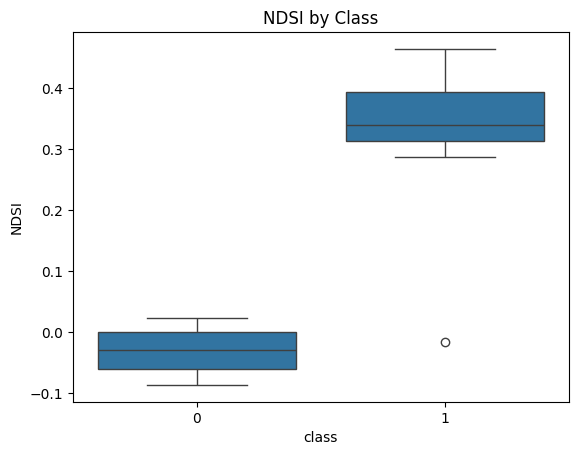

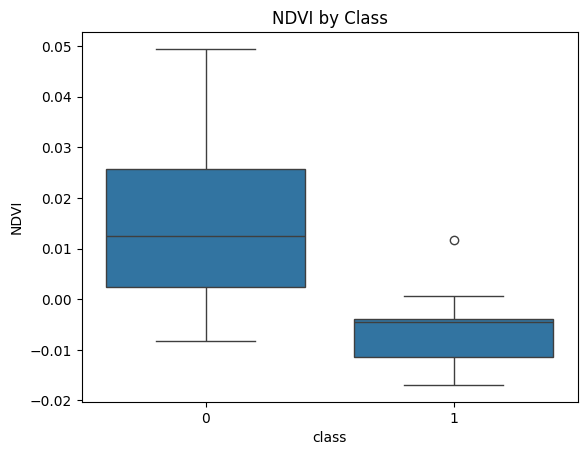

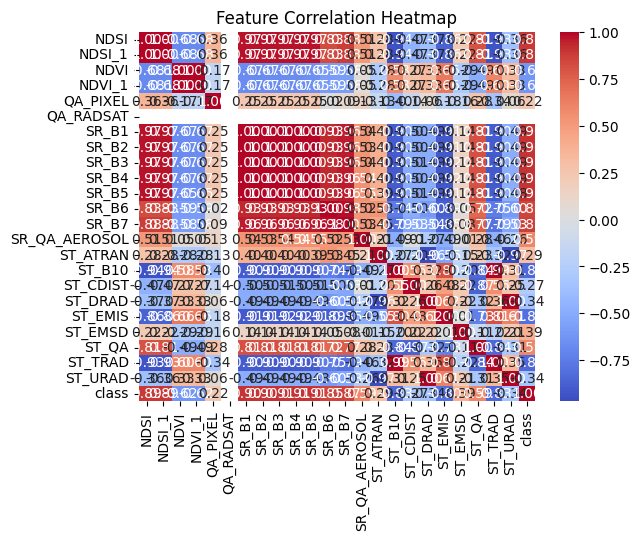

In [24]:
import seaborn as sns
import matplotlib.pyplot as plt

# Distribution of NDSI and NDVI by class
sns.boxplot(x='class', y='NDSI', data=df_clean)
plt.title('NDSI by Class')
plt.show()

sns.boxplot(x='class', y='NDVI', data=df_clean)
plt.title('NDVI by Class')
plt.show()

# Correlation heatmap
sns.heatmap(df_clean.corr(), annot=True, fmt=".2f", cmap='coolwarm')
plt.title("Feature Correlation Heatmap")
plt.show()

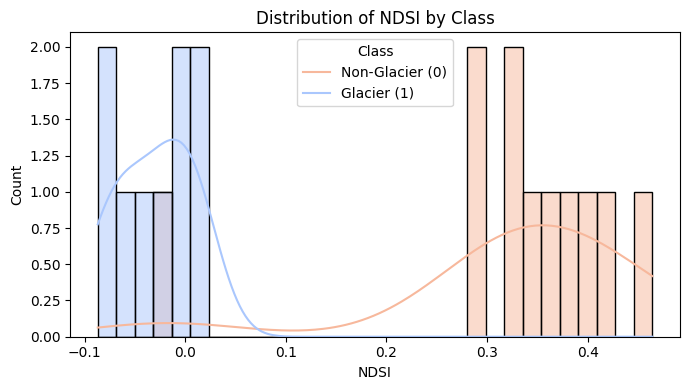

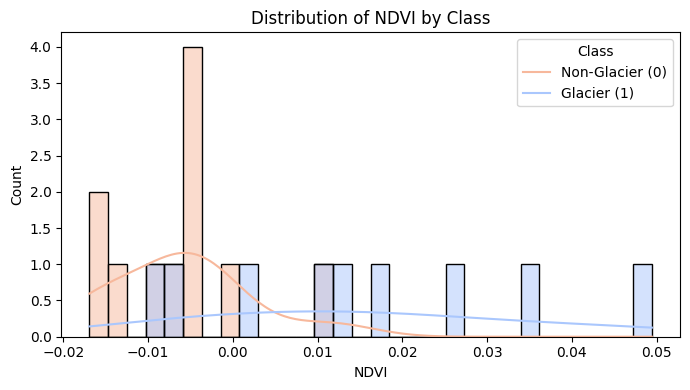

In [25]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot histograms for NDSI and NDVI
features = ['NDSI', 'NDVI']
for feature in features:
    plt.figure(figsize=(7, 4))
    sns.histplot(data=df_clean, x=feature, hue='class', kde=True, palette='coolwarm', bins=30)
    plt.title(f'Distribution of {feature} by Class')
    plt.xlabel(feature)
    plt.ylabel('Count')
    plt.legend(title='Class', labels=['Non-Glacier (0)', 'Glacier (1)'])
    plt.tight_layout()
    plt.show()

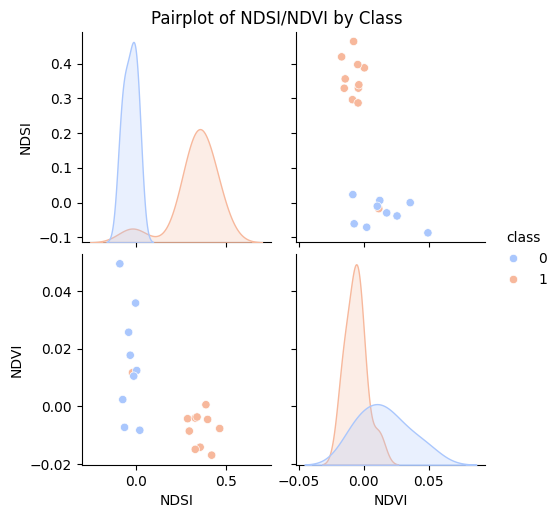

In [26]:
# Only select relevant columns
plot_features = ['NDSI', 'NDVI', 'class']
sns.pairplot(df_clean[plot_features], hue='class', palette='coolwarm', diag_kind='kde')
plt.suptitle("Pairplot of NDSI/NDVI by Class", y=1.02)
plt.show()


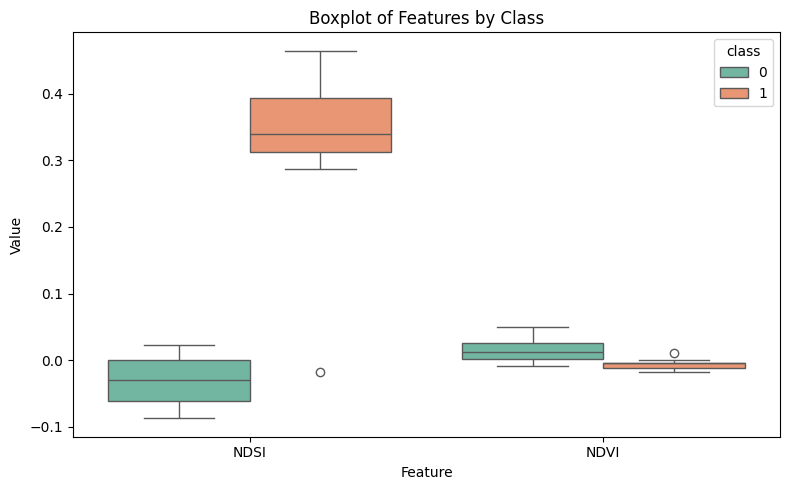

In [27]:
# Melt the DataFrame for boxplotting
melted = df_clean.melt(id_vars='class', value_vars=['NDSI', 'NDVI'])

plt.figure(figsize=(8, 5))
sns.boxplot(x='variable', y='value', hue='class', data=melted, palette='Set2')
plt.title("Boxplot of Features by Class")
plt.xlabel("Feature")
plt.ylabel("Value")
plt.tight_layout()
plt.show()


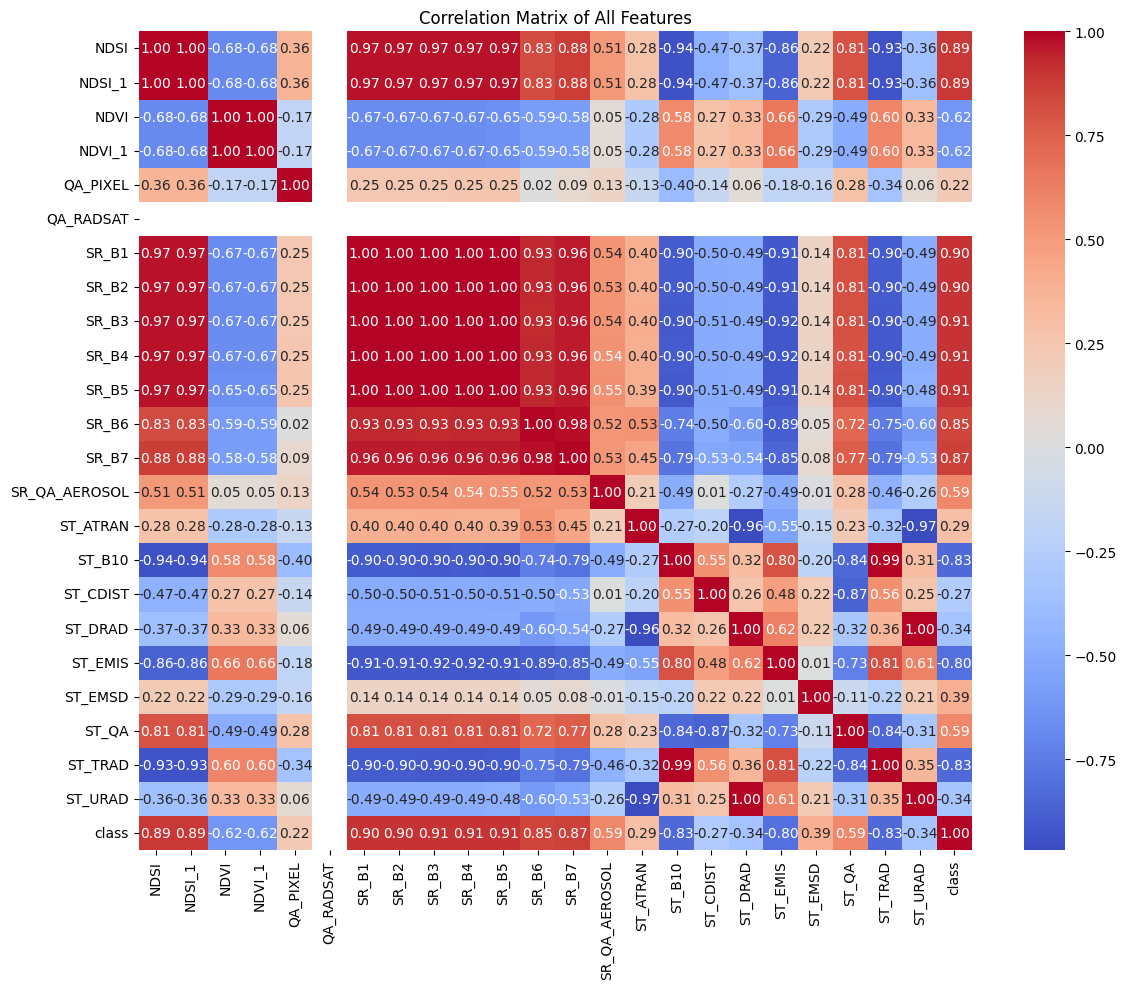

In [28]:
plt.figure(figsize=(12, 10))
sns.heatmap(df_clean.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix of All Features")
plt.tight_layout()
plt.show()
